# Final Image & Caption joint training

https://gist.github.com/elkhand/412f9dc4cd1a72c4571354e81c93d695

In [1]:
# Imports for Caption model

import os, sys, io,re, string, pathlib, random
from collections import Counter, OrderedDict

import hecutils.data_utils as dt
import hecutils.scoring_utils as sc
import hecutils.plotting_utils as pt
import hecutils.caption_utils as caput
import hecutils.image_utils as imut
import hecutils.text_utils as tu


import tensorflow as tf
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.layers import Dense, Conv1D, MaxPooling1D, GRU, Bidirectional, LSTM
from keras.layers.core import Dropout, Flatten, Masking, ActivityRegularization
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils import plot_model
from keras import regularizers
from keras.preprocessing import text
from keras.layers.embeddings import Embedding
from keras import layers

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.utils import shuffle, class_weight
from sklearn.model_selection import StratifiedKFold, train_test_split

import numpy as np
import pandas as pd


from gensim.models import word2vec
from gensim.models.keyedvectors import KeyedVectors

import matplotlib.pyplot as plt
import time

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline

################################################################################################################
# Imports for Image model

import os, sys, re, string, pathlib, random, io, time, glob
from collections import Counter, OrderedDict
from shutil import copyfile, rmtree

#import hecutils.resnet152 as resnet
from hecutils.resnet152 import ResNet152

import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

import hecutils.data_utils as dt
import hecutils.scoring_utils as sc
import hecutils.plotting_utils as pt
import hecutils.image_utils as imut

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


import tensorflow as tf
from keras import backend as K
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from keras.layers import Concatenate, MaxPooling2D, Conv2D, ZeroPadding2D, merge, Input, GRU, Bidirectional, LSTM, MaxPooling1D, Conv1D,Dense, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers.core import Dropout, Flatten, Masking, ActivityRegularization
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.inception_v3 import InceptionV3#, preprocess_input
#from imagenet_utils import preprocess_input
from keras_applications import imagenet_utils
preprocess_input = imagenet_utils.preprocess_input
from keras.applications.vgg16 import VGG16

from keras.preprocessing import text
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import Model
from keras import optimizers
from keras.regularizers import l2

# from fastText import load_model
from gensim.models import word2vec
from gensim.models.keyedvectors import KeyedVectors


import numpy as np
import pandas as pd
from sklearn.utils import shuffle, class_weight
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix

from os import listdir
from os.path import isfile, join




%matplotlib inline 

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

None


Using TensorFlow backend.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set Keras to use Tensorflow GPU in the backend

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

num_cores = 8
GPU=True
CPU = not GPU

if GPU:
    num_GPU = 1
    num_CPU = 8
if CPU:
    num_CPU = 8
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
session = tf.Session(config=config)
K.set_session(session)

## Global variables

In [3]:
# Caption model
# fix random seed for reproducibility
seed = 7

oasis_csv_path = "dataset/metadata/OASIS.csv"
captions_root = "/home/elkhand/git-repos/human-emotions-classifier/dataset/metadata"
captions_root_path = pathlib.Path(captions_root)
human_output_caption_to_label_csv_path = captions_root_path/'humanCaptionWithLabeldf.csv'
human_caption_csv_path = captions_root_path/'captions.csv'
#fasttext_embedding_path = 'embedding/wiki-news-300d-1M.vec'
fasttext_embedding_path = '/home/elkhand/datasets/glove-vectors/glove.twitter.27B.100d.txt'
#model_results_root_dir = "model/"
inputDataset_csv_path = captions_root_path/"inputDataset.csv"
testDataset_csv_path = captions_root_path/"testDataset.csv"

neutralLow = 3.0 
neutralHigh = 5.0

auto_output_caption_to_label_csv_path = captions_root_path/'autoCaptionWithLabeldf.csv'
auto_caption_csv_path = captions_root_path/'auto_generated_captions.csv'


dataset_path = human_output_caption_to_label_csv_path
# dataset_path = auto_output_caption_to_label_csv_path

kfold_splits = 7 # 10 # 7 # 5 # 10 # 7 
test_size = 0.1

embedding_dimension = 100 #200 # 300
hidden_layer_dim = 32
batch_size = 16 # 64
nb_epochs = 100
dropout = 0.3
recurrent_dropout=  0.6
patience = 10
verbose = 1

useF1Score = False # True

################################################################################################################
# Image model

oasis_csv_path = "dataset/metadata/OASIS.csv"
oasis_images_src = "dataset/images/"
input_images_src = "dataset/input-joint/"
test_images_src = "dataset/test-joint/"
model_results_root_dir = "img_model-joint/"

input_images_classified = "dataset/input-classified-joint/"
test_images_classified = "dataset/test-classified-joint/"

# ou can downlaod weights here: https://gist.github.com/flyyufelix/7e2eafb149f72f4d38dd661882c554a6
weights_path = "/home/elkhand/weights/resnet152_weights_tf.h5"

dataset_groups=["train", "val"]
classes = ["negative", "neutral", "positive"]

# fix random seed for reproducibility
seed = 7

test_size = 0.1

kfold_splits =  7 #5

neutralLow = 3.0
neutralHigh = 5.0

nb_epochs = 100
patience = 10 # ReduceLROnPlateau has 5
batch_size = 32 # 32  

FC_SIZE = 128 # 1024
LAYERS_TO_UNFREEZE = 10

img_height = 224 # 299
img_width = 224  # 299

useF1Score = False
verbose=1 



In [4]:
# Create <caption,label> CSV files
dt.create_caption_to_label(oasis_csv_path,human_caption_csv_path, human_output_caption_to_label_csv_path,neutralLow, neutralHigh)
dt.create_caption_to_label(oasis_csv_path,auto_caption_csv_path, auto_output_caption_to_label_csv_path,neutralLow, neutralHigh)

# ============================================

# Divide data into train/val/test datasets <imageName, caption, label>
# ============================================

dfImageIdCaptionLabel = pd.read_csv(dataset_path, header=0, sep="|")
dfImageIdCaptionLabel.columns = ["id","caption", "label"]
dfImageIdCaptionLabel["caption"] = dfImageIdCaptionLabel["caption"].apply(lambda x: " ".join(caput.get_words_withoutstopwords(x.lower().split())))
#dfImageIdCaptionLabel["label"] = dfImageIdCaptionLabel["label"].apply(lambda x: caput.change_label_str_to_int(x))


dfImageIdImageName = dt.get_image_id_to_image_title_as_df(oasis_csv_path)
dfImageIdImageName.columns = ['id', 'image_name']
dfImageIdImageName['image_name'] = dfImageIdImageName['image_name'].apply(lambda x: x + ".jpg") 
printCnt = 5
# has [id, caption, label]
df = pd.merge(dfImageIdCaptionLabel, dfImageIdImageName, on="id")
#print(df.head(printCnt))



input_x, test_x, input_y,  test_y = train_test_split(df["id"],
                                                     df["label"],
                                                     test_size=test_size,
                                                     random_state=seed,
                                                     stratify=df["label"])

inputDataset = pd.concat([input_x, input_y], axis=1)
testDataset = pd.concat([test_x, test_y], axis=1)

inputDataset = inputDataset.dropna()
testDataset = testDataset.dropna()
inputDataset = inputDataset.reset_index()
testDataset = testDataset.reset_index()

# print("inputDataset\n", inputDataset.head(10))
# print("testDataset\n", testDataset.head(10))

print("\n")
print("Label distribution in inputDataset", inputDataset.groupby('label').label.count())
print("Label distribution in testDataset", testDataset.groupby('label').label.count())


inputData = df.loc[df['id'].isin(inputDataset.id)]
testData = df.loc[df['id'].isin(testDataset.id)]

# print("inputData\n", inputData.head())
# print("testData\n", testData.head())

inputIds = set(inputData['id'].values)
testIds = set(testData['id'].values)

print("Input data size", len(inputIds))
print("Test data size", len(testIds))

for inputId in inputIds:
    if inputId in testIds:
        raise inputId + " inputId exists both in test and input dataset"
        
for testId in testIds:
    if testId in inputIds:
        raise testId + " testId exists both in test and input dataset"        

inputData.head()



Label distribution in inputDataset label
negative    147
neutral     378
positive    285
Name: label, dtype: int64
Label distribution in testDataset label
negative    16
neutral     42
positive    32
Name: label, dtype: int64
Input data size 810
Test data size 90


,id,caption,label,image_name
0,I1,two acorns lying ground next oak leaves.,neutral,Acorns 1.jpg
2,I100,ruined walls church backdrop white clouds blue...,neutral,Building 2.jpg
3,I101,man free fall attached blue bungee jumping app...,neutral,Bungee jumping 1.jpg
4,I102,falling man attached bungee jumping apparatus....,neutral,Bungee jumping 2.jpg
6,I104,man kneeling front tent two similar-looking gi...,positive,Camping 1.jpg


## Creating test and input dataset, and `positive,neutral,negative` under each dataset

In [5]:
# Delete input images dir
rmtree(input_images_src, ignore_errors=True)
os.makedirs(input_images_src)


# Delete test images dir
rmtree(test_images_src, ignore_errors=True)
os.makedirs(test_images_src)




# Copy input images into input dir, and test images into test dir
imut.copy_imgs_into(oasis_images_src, inputData['image_name'], input_images_src)
imut.copy_imgs_into(oasis_images_src, testData['image_name'], test_images_src)

# Divide input images into train and dev set, and each one into {negative, neutral, positive}
isForTest = False
X_train = inputData['image_name']
y_train = inputData['label']
dt.create_dataset("train", input_images_src, input_images_classified, X_train, y_train, isForTest)
#X_val = inputData['image_name'] # TODO COrrect
#y_val = inputData['label']
#dt.create_dataset("val", input_images_src, input_images_classified, X_val, y_val, isForTest)

## Loading Fasttext Embeddings

You can download fasttext word vectors from here:

https://fasttext.cc/docs/en/english-vectors.html

https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki-news-300d-1M.vec.zip


In [6]:
def load_embedding(path):
    word2vec = {}
    with io.open(path, encoding="utf8") as f:
        for line in f:
            entries = line.rstrip().split(" ")
            word, entries = entries[0], entries[1:]
            word2vec[word] = np.array(entries).astype(np.float) # Convert String type to float
    print('embedding size : %d' % len(word2vec))
    print('embedding dimension : %s' % (word2vec['apple'].shape,))
    return word2vec
    
print("fasttext_embedding_path", fasttext_embedding_path)
wordToVec = {}
wordToVec = load_embedding(fasttext_embedding_path)



fasttext_embedding_path /home/elkhand/datasets/glove-vectors/glove.twitter.27B.100d.txt
embedding size : 1193514
embedding dimension : (100,)


In [7]:
# https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py
MAX_SEQUENCE_LENGTH = 30
max_seq_len = MAX_SEQUENCE_LENGTH
MAX_NB_WORDS = 200000
embedding_dimension = 100
EMBEDDING_DIM = embedding_dimension
VALIDATION_SPLIT = 0.2


train_caption_words, train_labels = tu.get_caption_words_labels(inputData)
test_caption_words, test_labels = tu.get_caption_words_labels(testData)

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(train_caption_words + test_caption_words)
train_sequence =  tokenizer.texts_to_sequences(train_caption_words)
test_sequence =  tokenizer.texts_to_sequences(test_caption_words)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

train_padded_sequence = pad_sequences(train_sequence, maxlen=MAX_SEQUENCE_LENGTH)
test_padded_sequence = pad_sequences(test_sequence, maxlen=MAX_SEQUENCE_LENGTH)


########################################
## prepare embeddings
########################################
print('Preparing embedding matrix')

nb_words = min(MAX_NB_WORDS, len(word_index))+1
embeddings_index = wordToVec
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Found 810 texts in test.csv
Found 90 texts in test.csv
Found 2241 unique tokens
Preparing embedding matrix
Null word embeddings: 36


## Joint model, which will learn both from images and captions together

In [8]:
def build_model(max_seq_len, num_of_classes, config): 
    if K.image_data_format() == 'channels_first':
        input_shape = (3, img_height, img_width)
    else:
        input_shape = (img_height, img_width, 3)
    
#     text_inputs = Input(shape=(None, config['embedding_dimension']))
# #     masking = Masking(mask_value=0., input_shape=(None, config['embedding_dimension']))(text_inputs) #input_shape=(None, config['embedding_dimension'])
#     lstm1 = LSTM(max_seq_len, return_sequences=True, dropout=config['dropout'], recurrent_dropout=config['recurrent_dropout'])(text_inputs)
#     branch_1 = LSTM(max_seq_len, dropout=config['dropout'], recurrent_dropout=config['recurrent_dropout'])(lstm1)    
    
    num_of_classes = 3
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedding_layer = Embedding(nb_words,
            EMBEDDING_DIM,
            weights=[embedding_matrix],
            input_length=MAX_SEQUENCE_LENGTH,
            trainable=False,name="embedding")
    embedded_sequences = embedding_layer(sequence_input)
    lstm1 = LSTM(max_seq_len, return_sequences=True, dropout=config['dropout'], recurrent_dropout=config['recurrent_dropout'], name="lstm1")(embedded_sequences)
    lstm2 = LSTM(max_seq_len, dropout=config['dropout'], recurrent_dropout=config['recurrent_dropout'], name="lstm2")(lstm1)
    branch_1 = lstm2
    
    
    # Image input branch - a pre-trained Inception module followed by an added fully connected layer
    #base_model = InceptionV3(weights='imagenet', include_top=False)
#     base_model = ResNet152(include_top=False, weights='imagenet')
#     base_model = InceptionResNetV2(weights='imagenet', include_top=False)
#     base_model = VGG16(include_top=False, weights='imagenet')
#     base_model.trainable = False


    # add a fully connected layer after Inception - we do want to train these
#     branch_2 = base_model.output
    
#     x = GlobalAveragePooling2D()(branch_2)
#     x = Dropout(0.5)(x)
#     x = Dense(FC_SIZE, activation='relu')(x) #new FC layer, random init
#     x = Dropout(0.5)(x)
#     branch_2 = x
    
#     # Block 1
    image_input = Input(shape=input_shape)
    model = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1' )(image_input)
    model = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2') (model)
    model = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool') (model)
    # Classification block
    model = Flatten(name='flatten') (model)
    branch_2 = model

    # merge the text input branch and the image input branch and add another fully connected layer
    #joint = merge([branch_1, branch_2], mode='concat')
    joint = layers.concatenate([branch_1, branch_2], axis=-1)
    joint = Dense(32, activation='relu')(joint)
    joint = Dropout(0.5)(joint)
    predictions = Dense(num_of_classes, activation='softmax')(joint)
    
    
    if config['useF1Score']:
        metrics = ['accuracy', sc.f1, sc.recall, sc.precision]
    else:
        metrics = ['accuracy']
        
#     full_model = Model(inputs=[base_model.input, sequence_input], outputs=[predictions])
    full_model = Model(inputs=[image_input, sequence_input], outputs=[predictions])

    full_model.compile(loss='categorical_crossentropy',
                   optimizer='adam', # 'rmsprop'
                   metrics=metrics)
#     print(full_model.summary())
    return full_model

def setup_to_finetune(model, useF1Score):
    """Freeze the bottom LAYERS_TO_FREEZE and retrain the remaining top layers.
  note: LAYERS_TO_FREEZE corresponds to the top 2 inception blocks in the inceptionv3 arch
  Args:
    model: keras model
    """    
    totalLayers = len(model.layers)
    lastFreezeLayer = totalLayers - LAYERS_TO_UNFREEZE
    print("LAYERS_TO_UNFREEZE:", LAYERS_TO_UNFREEZE, "last layer id to freeze", lastFreezeLayer, "total layers, ",totalLayers)
    for layer in model.layers[:lastFreezeLayer]:
        layer.trainable = False
    for layer in model.layers[lastFreezeLayer:]:
        layer.trainable = True
    #optimizers.SGD(lr=0.0001, momentum=0.9)
    model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy',\
                  metrics=imut.get_metrics(useF1Score))
    
def get_config():
    conf = {}
    conf["kfold_splits"] = kfold_splits
    conf["batch_size"] = batch_size
    conf['embedding_dimension'] = embedding_dimension
    conf['recurrent_dropout'] = recurrent_dropout
    conf['dropout'] = dropout
    conf["nb_epochs"] = nb_epochs
    conf['useF1Score'] = useF1Score
    conf['verbose'] = verbose
    conf['useF1Score'] = useF1Score
    conf['seed'] = seed
    conf["img_height"] = img_height
    conf["img_width"] = img_width
    conf["kfold_splits"] = kfold_splits
    conf["batch_size"] = batch_size
    conf["nb_epochs"] = nb_epochs
    conf['useF1Score'] = useF1Score
    conf['verbose'] = verbose
    return conf 



## Load images into memory

In [9]:
X_train = []
cnt = 0
# https://github.com/fchollet/deep-learning-models
for img_name in inputData['image_name']:
    fpath = input_images_src + img_name
    cnt += 1
    print(fpath)
    img = load_img(fpath, target_size=(224,224))
    x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
    #x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    X_train.append(x)

dataset/input-joint/Acorns 1.jpg
dataset/input-joint/Building 2.jpg
dataset/input-joint/Bungee jumping 1.jpg
dataset/input-joint/Bungee jumping 2.jpg
dataset/input-joint/Camping 1.jpg
dataset/input-joint/Camping 2.jpg
dataset/input-joint/Camping 4.jpg
dataset/input-joint/Camping 6.jpg
dataset/input-joint/Camping 7.jpg
dataset/input-joint/Alcohol 8.jpg
dataset/input-joint/Camping 10.jpg
dataset/input-joint/Candle 1.jpg
dataset/input-joint/Car 1.jpg
dataset/input-joint/Car 2.jpg
dataset/input-joint/Car accident 2.jpg
dataset/input-joint/Car accident 3.jpg
dataset/input-joint/Car accident 4.jpg
dataset/input-joint/Ambulance 1.jpg
dataset/input-joint/Car crash 1.jpg
dataset/input-joint/Car crash 2.jpg
dataset/input-joint/Car crash 3.jpg
dataset/input-joint/Car race 1.jpg
dataset/input-joint/Car race 2.jpg
dataset/input-joint/Car race 3.jpg
dataset/input-joint/Car race 4.jpg
dataset/input-joint/Cardboard 1.jpg
dataset/input-joint/Cardboard 2.jpg
dataset/input-joint/Cardboard 3.jpg
dataset/i

dataset/input-joint/Frisbee 1.jpg
dataset/input-joint/Frustrated pose 3.jpg
dataset/input-joint/Frustrated pose 4.jpg
dataset/input-joint/Frustrated pose 5.jpg
dataset/input-joint/Frustrated pose 6.jpg
dataset/input-joint/Frustrated pose 7.jpg
dataset/input-joint/Frustrated pose 8.jpg
dataset/input-joint/Baby 6.jpg
dataset/input-joint/Galaxy 1.jpg
dataset/input-joint/Galaxy 2.jpg
dataset/input-joint/Galaxy 3.jpg
dataset/input-joint/Galaxy 4.jpg
dataset/input-joint/Galaxy 5.jpg
dataset/input-joint/Galaxy 6.jpg
dataset/input-joint/Galaxy 7.jpg
dataset/input-joint/Galaxy 8.jpg
dataset/input-joint/Garbage dump 1.jpg
dataset/input-joint/Baby 7.jpg
dataset/input-joint/Garbage dump 2.jpg
dataset/input-joint/Garbage dump 3.jpg
dataset/input-joint/Garbage dump 4.jpg
dataset/input-joint/Garbage dump 5.jpg
dataset/input-joint/Garbage dump 6.jpg
dataset/input-joint/Garbage dump 7.jpg
dataset/input-joint/Garbage dump 8.jpg
dataset/input-joint/Gargoyle 1.jpg
dataset/input-joint/Gargoyle 2.jpg
datase

dataset/input-joint/Phone 1.jpg
dataset/input-joint/Beach 4.jpg
dataset/input-joint/Picnic 2.jpg
dataset/input-joint/Picnic 3.jpg
dataset/input-joint/Picnic 4.jpg
dataset/input-joint/Pig 1.jpg
dataset/input-joint/Pig 2.jpg
dataset/input-joint/Pigeon 1.jpg
dataset/input-joint/Pigeon 3.jpg
dataset/input-joint/Pigeon 4.jpg
dataset/input-joint/Beach 5.jpg
dataset/input-joint/Pigeon 5.jpg
dataset/input-joint/Pigeon 6.jpg
dataset/input-joint/Pinecone 1.jpg
dataset/input-joint/Pinecone 2.jpg
dataset/input-joint/Pinecone 3.jpg
dataset/input-joint/Pinecone 4.jpg
dataset/input-joint/Plane crash 1.jpg
dataset/input-joint/Plane crash 2.jpg
dataset/input-joint/Plane crash 3.jpg
dataset/input-joint/Plane crash 4.jpg
dataset/input-joint/Beach 6.jpg
dataset/input-joint/Police 1.jpg
dataset/input-joint/Police 2.jpg
dataset/input-joint/Police 4.jpg
dataset/input-joint/Police 5.jpg
dataset/input-joint/Pollution 1.jpg
dataset/input-joint/Power lines 1.jpg
dataset/input-joint/Present 2.jpg
dataset/input-jo

dataset/input-joint/Wedding 9.jpg
dataset/input-joint/Wedding 10.jpg
dataset/input-joint/Wedding 11.jpg
dataset/input-joint/Wedding ring 1.jpg
dataset/input-joint/Windmill 1.jpg
dataset/input-joint/Wolf 1.jpg
dataset/input-joint/Wolf 2.jpg
dataset/input-joint/Bored pose 4.jpg
dataset/input-joint/Woods 1.jpg
dataset/input-joint/Yarn 1.jpg
dataset/input-joint/Yarn 2.jpg
dataset/input-joint/Yarn 3.jpg
dataset/input-joint/Yarn 4.jpg
dataset/input-joint/Yoga 1.jpg
dataset/input-joint/Yoga 2.jpg
dataset/input-joint/Yoga 3.jpg
dataset/input-joint/Yoga 4.jpg
dataset/input-joint/Yoga 5.jpg
dataset/input-joint/Alcohol 6.jpg
dataset/input-joint/Bored pose 5.jpg
dataset/input-joint/Zebra 1.jpg
dataset/input-joint/Bored pose 6.jpg
dataset/input-joint/Bottle 1.jpg
dataset/input-joint/Boxing 1.jpg
dataset/input-joint/Boxing 2.jpg
dataset/input-joint/Bridge 1.jpg
dataset/input-joint/Bubble 1.jpg
dataset/input-joint/Bubble 2.jpg
dataset/input-joint/Building 1.jpg


In [10]:
X = inputData["caption"]
y = inputData["label"]

max_seq_len = int(inputData['caption'].map(lambda x: caput.get_non_stop_word_count(x.split())).max())


dfTrain = pd.concat([X, y], axis=1)
dfTrain.columns = ['caption', 'label']

dfTrain = inputData

class_to_index = {}
index_to_class = {}

X_train_text, y_train_index, num_of_classes, class_to_index, index_to_class, filenames = \
            caput.load_dataset_StratifiedKFold(
                            dfTrain,
                            wordToVec, 
                            max_seq_len, 
                            class_to_index, 
                            index_to_class,
                            get_config())
y_train = caput.convert_index_to_one_hot(y_train_index, num_of_classes) 
print("filenames",filenames)        

filenames ['Acorns 1.jpg', 'Building 2.jpg', 'Bungee jumping 1.jpg', 'Bungee jumping 2.jpg', 'Camping 1.jpg', 'Camping 2.jpg', 'Camping 4.jpg', 'Camping 6.jpg', 'Camping 7.jpg', 'Alcohol 8.jpg', 'Camping 10.jpg', 'Candle 1.jpg', 'Car 1.jpg', 'Car 2.jpg', 'Car accident 2.jpg', 'Car accident 3.jpg', 'Car accident 4.jpg', 'Ambulance 1.jpg', 'Car crash 1.jpg', 'Car crash 2.jpg', 'Car crash 3.jpg', 'Car race 1.jpg', 'Car race 2.jpg', 'Car race 3.jpg', 'Car race 4.jpg', 'Cardboard 1.jpg', 'Cardboard 2.jpg', 'Cardboard 3.jpg', 'Ambulance 2.jpg', 'Cat 1.jpg', 'Cat 2.jpg', 'Cat 3.jpg', 'Cat 4.jpg', 'Cat 5.jpg', 'Cat 6.jpg', 'Cat 7.jpg', 'Cat 8.jpg', 'Cat 9.jpg', 'Cat 10.jpg', 'Ambulance 3.jpg', 'Cat 11.jpg', 'Cat 12.jpg', 'Cat 13.jpg', 'Cat 14.jpg', 'Celebration 1.jpg', 'Celebration 2.jpg', 'Cemetery 1.jpg', 'Cemetery 2.jpg', 'Cemetery 3.jpg', 'Cemetery 4.jpg', 'Angry face 1.jpg', 'Cemetery 5.jpg', 'Cheerleader 1.jpg', 'Cheerleader 2.jpg', 'Child labor 2.jpg', 'Child labor 3.jpg', 'Child labor 

## Run model

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
[[1. 0. 0.]
 [1. 0. 0.]]
<class 'numpy.ndarray'>
batch_size 32
Train on 729 samples, validate on 81 samples
Epoch 1/10
729/729 [==============================] - 6s 9ms/step - loss: 9.2875 - acc: 0.4198 - val_loss: 6.7656 - val_acc: 0.5802
Epoch 2/10
729/729 [==============================] - 4s 5ms/step - loss: 9.7505 - acc: 0.3951 - val_loss: 6.7656 - val_acc: 0.5802
Epoch 3/10
729/729 [==============================] - 4s 5ms/step - loss: 9.6399 - acc: 0.4019 - val_loss: 6.7656 - val_acc: 0.5802
Epoch 4/10
729/729 [==============================] - 4s 5ms/step - loss: 9.5515 - acc: 0.4074 - val_loss: 6.7656 - val_acc: 0.5802
Epoch 5/10
729/729 [==============================] - 4s 5ms/step - loss: 9.1756 - acc: 0.4307 - val_loss: 6.7656 - val_acc: 0.5802
Epoch 6/10
729/729 [==============================] - 4s 5ms/step - loss: 9.3304 - acc: 0.4211 - val_loss: 6.7656 - val_acc: 0.5802

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.000

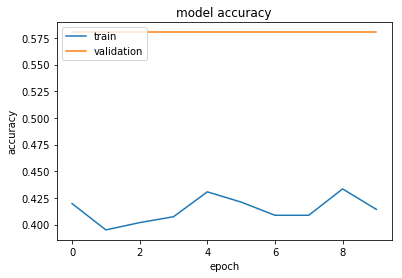

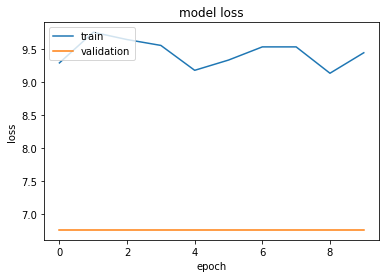

In [11]:
epochs = 2
print(y_train[:3])
y_train = np.array(y_train)
print(y_train[:2])
print(type(y_train))


reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                  factor=0.7, 
                                  patience=5,
                                  min_delta=0.0001,
                                  cooldown=1,
                                  min_lr=1e-7,
                                  verbose=verbose)

logs_dir = "logs"
rmtree(logs_dir, ignore_errors=True)
os.makedirs(logs_dir)

tfBoard = TensorBoard(log_dir=logs_dir,histogram_freq=1,
#                       embeddings_freq=1, 
#                       embeddings_layer_names=None,
#                       embeddings_metadata=None,
                      write_images=True) # 

early_stopping = EarlyStopping(monitor='val_loss', patience=patience)    
callbacks_list = [early_stopping, reduce_lr, tfBoard] #

printCnt = 10
X_train, X_train_text, y_train= np.array(X_train), np.array(X_train_text), np.array(y_train)
X_train, X_train_text, y_train = shuffle(X_train, X_train_text, y_train)
batch_size = 32 
print("batch_size", batch_size)

K.clear_session()
full_model = build_model(40, 3, get_config())
history = full_model.fit([X_train, train_padded_sequence], train_labels,
                                   batch_size=batch_size,
                                   epochs=10,
                                   #shuffle=True,
                                   validation_split=0.1,
                                   callbacks=callbacks_list,
                                   #class_weight=class_weights,
                                   verbose=1) 


# LAYERS_TO_UNFREEZE = 20
# setup_to_finetune(full_model, False)
# history = full_model.fit([X_train, train_padded_sequence], train_labels,
#                                    batch_size=batch_size,
#                                    epochs=100,
#                                    shuffle=True,
#                                    validation_split=0.1,
#                                    callbacks=callbacks_list,
#                                    #class_weight=class_weights,
#                                    verbose=1) 

# history = full_model.fit([X_train, X_train_text], y_train,
#                                    batch_size=batch_size,
#                                    epochs=100,
#                                    #shuffle=True,
#                                    validation_split=0.1,
#                                    callbacks=callbacks_list,
#                                    #class_weight=class_weights,
#                                    verbose=1) 

# LAYERS_TO_UNFREEZE = 20
# setup_to_finetune(full_model, False)
# history = full_model.fit([X_train, X_train_text], y_train,
#                                    batch_size=batch_size,
#                                    epochs=100,
#                                    shuffle=True,
#                                    validation_split=0.1,
#                                    callbacks=callbacks_list,
#                                    #class_weight=class_weights,
#                                    verbose=1) 

useF1Score = False
pt.plot_model_accuracy(history, model_results_root_dir, useF1Score)
#,  validation_split=0.2,epochs=epochs,
#  steps_per_epoch=  2000 // get_config()['batch_size'],

In [12]:
print("train_labels",train_labels)
print("\n")

print("y_train",y_train)

inputData['label']

train_labels [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


y_train [[0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


0       neutral
2       neutral
3       neutral
4       neutral
6      positive
7       neutral
9      positive
10      neutral
11     positive
12     positive
15      neutral
16     positive
17     positive
18      neutral
20     negative
21     negative
22     negative
23     negative
24     negative
25     negative
26     negative
27      neutral
28      neutral
29      neutral
30      neutral
31      neutral
32      neutral
33      neutral
34      neutral
35     positive
         ...   
868    positive
869    positive
870    positive
871    positive
873    positive
874     neutral
875    positive
876     neutral
877     neutral
878     neutral
879    negative
880     neutral
881     neutral
882     neutral
883    positive
884     neutral
885    positive
886    positive
887     neutral
888     neutral
889     neutral
890    positive
891     neutral
892     neutral
893     neutral
894     neutral
896    positive
897     neutral
898    positive
899    positive
Name: label, Length: 810